# Explanation Title
--This is where the explanation will go--

In [13]:
### IMPORTS

# Standard library
from datetime import datetime
import warnings

# Third-party libraries
import numpy as np
import pandas as pd
import requests
import matplotlib.pyplot as plt
import torch
from scipy.stats import genpareto, kurtosis
from sklearn.linear_model import LinearRegression
from arch import arch_model
from statsmodels.tsa.regime_switching.markov_regression import MarkovRegression
from statsmodels.tools.sm_exceptions import ConvergenceWarning

# Local modules
from ARCHIVE.V1.V1_secret import API_TOKEN

# Config
warnings.filterwarnings("ignore", category=ConvergenceWarning)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [14]:
### LOGGING

import json, time, logging


class Config:
    LOG_DIR = "logs"
    SCR_DIR = "screenshots"

class JsonFormatter(logging.Formatter):
    """
    True JSON formatter: includes ISO-8601 timestamp, source, and supports exceptions.
    """
    def format(self, record: logging.LogRecord) -> str:
        base = {
            "time": self.formatTime(record),
            "level": record.levelname,
            "logger": record.name,
            "module": record.module,
            "func": record.funcName,
            "line": record.lineno,
            "message": record.getMessage(),
        }
        if record.exc_info:
            base["exc_info"] = self.formatException(record.exc_info)
        return json.dumps(base, ensure_ascii=False)

    def formatTime(self, record, datefmt=None):
        # ISO-8601 with milliseconds
        t = self.converter(record.created) if hasattr(self, "converter") else time.localtime(record.created)
        s = time.strftime("%Y-%m-%dT%H:%M:%S", t)
        return f"{s}.{int(record.msecs):03d}"

class Logger:
    """
    Structured JSON logging to console (INFO) + rotating file (DEBUG).
    Idempotent: calling setup() multiple times will not add duplicate handlers.
    """
    @staticmethod
    def setup(name: str = "fractal",
              log_dir: str = Config.LOG_DIR,
              max_bytes: int = 5_000_000,
              backups: int = 3,
              console_level: int = logging.INFO,
              file_level: int = logging.DEBUG) -> logging.Logger:

        logger = logging.getLogger(name)
        logger.setLevel(logging.DEBUG)
        logger.propagate = False  # avoid double logs via root

        # If already configured, return as-is
        if getattr(logger, "_fractal_configured", False):
            return logger

        fmt = JsonFormatter()

        # Console handler
        ch = logging.StreamHandler()
        ch.setLevel(console_level)
        ch.setFormatter(fmt)
        logger.addHandler(ch)

        logger._fractal_configured = True
        return logger

def log_method(fn):
    """
    Decorator: logs entry/exit + elapsed time; captures exceptions with traceback.
    Assumes 'self.logger' exists; otherwise falls back to 'fractal' logger.
    """
    import functools, time as _time
    @functools.wraps(fn)
    def wrapper(self, *args, **kwargs):
        logger = getattr(self, "logger", logging.getLogger("fractal"))
        name = f"{self.__class__.__name__}.{fn.__name__}"
        logger.info(f"▶ Starting {name}")
        start = _time.time()
        try:
            result = fn(self, *args, **kwargs)
            elapsed = _time.time() - start
            logger.info(f"✔ Finished {name} in {elapsed:.2f}s")
            return result
        except Exception:
            elapsed = _time.time() - start
            logger.exception(f"✖ Error in {name} after {elapsed:.2f}s")
            raise
    return wrapper


In [15]:
### DATA COLLECTION AND PLOTTING

# data collection
def get_daily_data(symbol, start_date, end_date, api_token, logger):
    """
    Fetch end‑of‑day price and volume for a given symbol from the EODHD API.
    Returns a DataFrame indexed by business‑day datetime with ‘close’ and ‘volume’ columns, or an empty DataFrame on failure.
    """
    logger.info(f"Fetching data for {symbol} from {start_date} to {end_date}")
    url  = f'https://eodhd.com/api/eod/{symbol}?api_token={api_token}&from={start_date}&to={end_date}&fmt=json'
    resp = requests.get(url)
    if resp.status_code == 200:
        df = pd.DataFrame(resp.json())
        if 'date' in df.columns:
            df['datetime'] = pd.to_datetime(df['date'])
            df = df.set_index('datetime').asfreq('B').rename_axis(None)
            return df[['close', 'volume']]
    logger.warning(f"No data for {symbol}")
    return pd.DataFrame()

# data cleaning
def clean_data(data):
    logger.info(f"Cleaning data for {data.shape[0]} rows")
    # Ensure DatetimeIndex, sorted, unique
    if not isinstance(data.index, pd.DatetimeIndex):
        data.index = pd.to_datetime(data.index)
    data = data.sort_index()
    data = data[~data.index.duplicated(keep='last')]
    # regularize to business days if your downstream requires it
    data = data.asfreq('B', method='pad')
    # Attach freq only if pandas can infer it
    inferred = pd.infer_freq(data.index)
    if inferred:
        data.index.freq = inferred
    # Fill residual NaNs; consider dropping bfill if backward fill is undesirable
    data = data.ffill().bfill()

    return data

# plotting
def plot_with_quantification(data, title):
    """
    Fit and plot a linear trend on the price series, then overlay ±1 σ and ±2 σ bands on the residuals.
    Highlights points outside ±1 σ and shows a Matplotlib figure annotated with mean and residual standard deviation.
    """
    df = data.copy().reset_index().rename(columns={'index':'datetime'})
    df['day_num'] = np.arange(len(df))
    X, y = df[['day_num']].values, df['close'].values
    model = LinearRegression().fit(X, y)
    df['trend'] = model.predict(X)
    resid   = y - df['trend']
    std_res = resid.std()
    mean_p  = df['close'].mean()
    df['in_upper'] = df['close'] > (df['trend'] + std_res)
    df['in_lower'] = df['close'] < (df['trend'] - std_res)
    plt.figure(figsize=(14,7))
    plt.plot(df['datetime'], df['close'],           label='Prix')
    plt.plot(df['datetime'], df['trend'],           label='Trend')
    plt.plot(df['datetime'], df['trend'] + std_res, '--', label='+1σ')
    plt.plot(df['datetime'], df['trend'] - std_res, '--', label='-1σ')
    plt.plot(df['datetime'], df['trend'] + 2*std_res,'-.',label='+2σ')
    plt.plot(df['datetime'], df['trend'] - 2*std_res,'-.',label='-2σ')
    plt.scatter(df.loc[df['in_upper'], 'datetime'], df.loc[df['in_upper'], 'close'],
                marker='o', s=40, color='crimson', edgecolors='none', label='> +1σ')
    plt.scatter(df.loc[df['in_lower'], 'datetime'], df.loc[df['in_lower'], 'close'],
                marker='o', s=40, color='purple', edgecolors='none', label='< -1σ')
    plt.title(f"{title} • Mean: {mean_p:.2f} • σ_res: {std_res:.2f}")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    # plt.savefig(f"{title.replace(' ', '_')}.png", dpi=300, bbox_inches='tight')
    plt.show()

{"time": "2025-09-09T16:27:29.499", "level": "INFO", "logger": "fractal", "module": "2251148097", "func": "get_daily_data", "line": 9, "message": "Fetching data for USDJPY.FOREX from 2024-09-09 to 2025-09-09"}


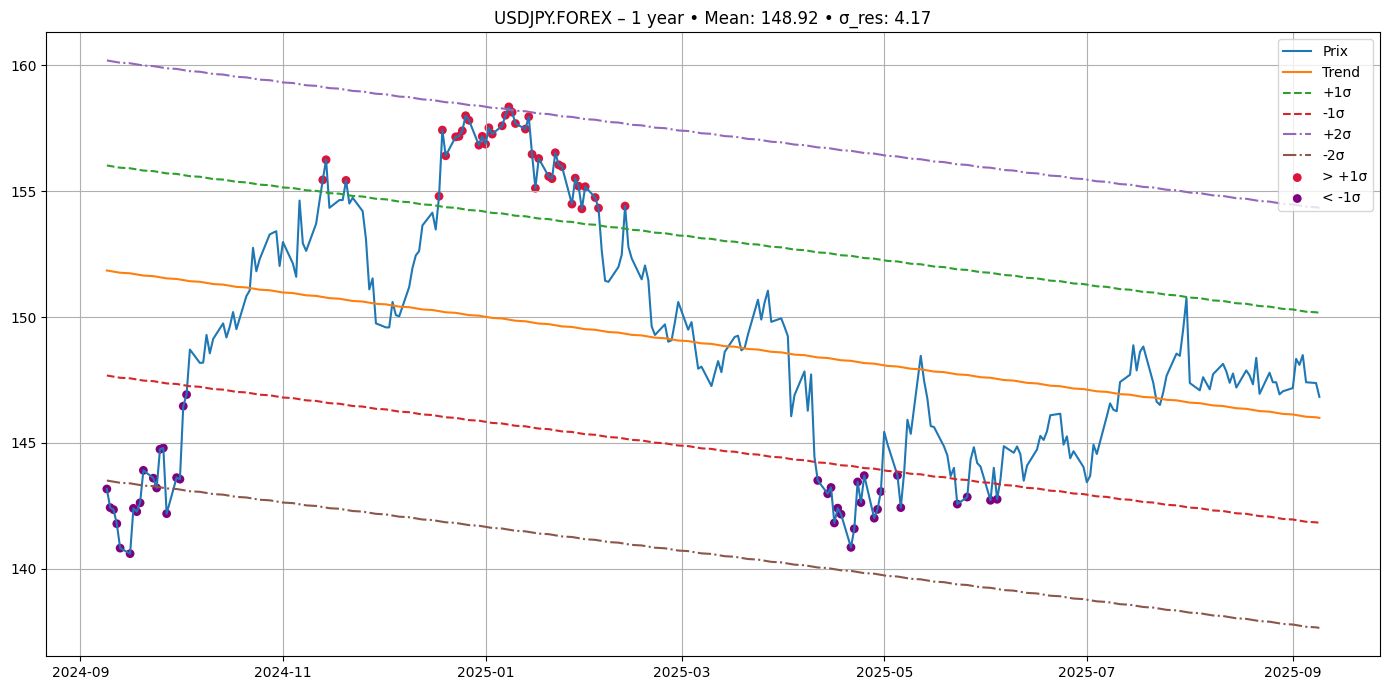

In [16]:
# TESTING PLOTTING

api_token = API_TOKEN
ticker = "USDJPY.FOREX"
end_date = pd.to_datetime('today').strftime('%Y-%m-%d')
logger = Logger.setup()

start_1y = (pd.to_datetime(end_date) - pd.DateOffset(years=1)) \
        .strftime('%Y-%m-%d')
data_1y = get_daily_data(ticker, start_1y, end_date, api_token, logger) \
        .resample('B').last().ffill()

plot_with_quantification(data_1y, f'{ticker} – 1 year')




In [17]:
### METRICS

class MetricAnalyzer:
    def __init__(self, data, logger: logging.Logger, timeout: int = 20):
        """
        Store a copy of the input DataFrame with a 'close' series.
        Prepares data for metric calculations.

        Parameters
        ----------
        data : pandas.DataFrame
            Must contain a 'close' column.

        Returns
        -------
        None
        """
        self.data = data.copy()
        self.logger = logger

    @log_method
    def quantify_queues_adaptive(self, window_homeo=30, window_fb=5):
        """
        Derive dynamic upper/lower thresholds from rolling variability and short‑term feedback,
        then quantify how often and how far prices breach those thresholds.

        Parameters
        ----------
        window_homeo : int, optional
            Window length for rolling std/mean homeostasis (default 30).
        window_fb : int, optional
            Window length for rolling positive vs negative return feedback (default 5).

        Returns
        -------
        dict
            prob_upper : float
                % of prices above the adaptive upper bound.
                High → frequent upside breaches; low → rare.
            prob_lower : float
                % of prices below the adaptive lower bound.
                High → frequent downside breaches; low → rare.
            mean_upper_excess : float
                Avg overshoot magnitude above upper bound (zero if none).
                Larger → more severe typical upside moves.
            max_upper_excess : float
                Max overshoot above upper bound (zero if none).
                Larger → most extreme single upside move.
            mean_lower_excess : float
                Avg undershoot magnitude below lower bound (zero if none).
                Larger → more severe typical downside moves.
            max_lower_excess : float
                Max undershoot below lower bound (zero if none).
                Larger → most extreme single downside move.
            homeostasis_coef : float
                Average rolling std/mean ratio; measures baseline variability.
                Higher → more relative fluctuation.
            feedback_coef : float
                Mean positive minus negative return rate; measures short‑term bias.
                Positive → more up‑moves, negative → more down‑moves.
        """
        data = self.data
        m, s = data['close'].mean(), data['close'].std()
        rs = data['close'].rolling(window_homeo).std()
        rm = data['close'].rolling(window_homeo).mean()
        homeo = (rs / rm).mean()
        r = data['close'].pct_change().dropna()
        fb_p = r.gt(0).rolling(window_fb).mean().mean()
        fb_m = r.lt(0).rolling(window_fb).mean().mean()
        feedback = fb_p - fb_m
        k_up, k_lo = homeo + feedback, homeo - feedback
        up, lo = m + k_up * s, m - k_lo * s
        in_up = data['close'] > up
        in_lo = data['close'] < lo
        return {
            'prob_upper': in_up.mean() * 100,
            'prob_lower': in_lo.mean() * 100,
            'mean_upper_excess': (data['close'][in_up] - up).mean() if in_up.any() else 0,
            'max_upper_excess': (data['close'][in_up] - up).max() if in_up.any() else 0,
            'mean_lower_excess': (lo - data['close'][in_lo]).mean() if in_lo.any() else 0,
            'max_lower_excess': (lo - data['close'][in_lo]).max() if in_lo.any() else 0,
            'homeostasis_coef': homeo,
            'feedback_coef': feedback
        }

    @log_method
    def calculate_asymmetry_adaptive(self, window_homeo=30, window_fb=5):
        """
        Compute net tilt of large upward vs downward moves using adaptive bounds.
        Positive → average upside overshoot exceeds downside undershoot.

        Parameters
        ----------
        window_homeo : int, optional
            Homeostasis window (default 30).
        window_fb : int, optional
            Feedback window (default 5).

        Returns
        -------
        float
            Difference = (mean(above – upper) − mean(lower − below)).
            Positive → stronger average upside moves; negative → stronger downside.
        """
        data = self.data
        m, s = data['close'].mean(), data['close'].std()
        rs = data['close'].rolling(window_homeo).std()
        rm = data['close'].rolling(window_homeo).mean()
        homeo = (rs / rm).mean()
        r = data['close'].pct_change().dropna()
        fb_p = r.gt(0).rolling(window_fb).mean().mean()
        fb_m = r.lt(0).rolling(window_fb).mean().mean()
        feedback = fb_p - fb_m
        k_up, k_lo = homeo + feedback, homeo - feedback
        up, lo = m + k_up * s, m - k_lo * s
        above = data['close'][data['close'] > up]
        below = data['close'][data['close'] < lo]
        if above.empty or below.empty:
            return 0.0
        return (above - up).mean() - (lo - below).mean()

    @log_method
    def analyze_extreme_values(self, threshold_quantile=0.95):
        """
        Fit a Generalized Pareto distribution to the tail of large positive moves.
        Quantifies shape, location and scale of extreme excursions beyond a high quantile.

        Parameters
        ----------
        threshold_quantile : float, optional
            Quantile for threshold (default 0.95).

        Returns
        -------
        tuple
            params : (shape, loc, scale)
                GPD parameters of excesses above threshold.
                Shape >0 → heavy tail; <0 → finite endpoint.
            threshold : float
                Value at the specified quantile, defines where tail begins.
        """
        data = self.data
        thresh = data['close'].quantile(threshold_quantile)
        exc = data['close'][data['close'] > thresh] - thresh
        if len(exc) < 2:
            return (np.nan, np.nan, np.nan), thresh
        return genpareto.fit(exc), thresh

    @log_method
    def calculate_risk_metrics(self, alpha=0.05):
        """
        Calculate Value at Risk and Expected Shortfall from returns.
        VaR is the alpha‑quantile loss, ES is the average of losses beyond VaR.

        Parameters
        ----------
        alpha : float, optional
            Tail probability (default 0.05).

        Returns
        -------
        tuple
            var : float
                The alpha‑quantile of returns (e.g. -0.05 means 5% worst loss).
            es : float
                Mean of returns ≤ var, measures average tail loss.
        """
        data = self.data
        r = data['close'].pct_change().dropna()
        if r.empty:
            return np.nan, np.nan
        var = np.percentile(r, alpha * 100)
        es = r[r <= var].mean()
        return var, es

    @log_method
    def analyze_metrics(self):
        """
        Run all metrics and collate results.
        Returns adaptive queue stats, extreme‑value threshold, asymmetry, and VaR.

        Returns
        -------
        dict
            All keys from quantify_queues_adaptive (see its return docs), plus:
            evt_threshold : float, threshold used for GPD fit (high quantile of 'close')
            asymmetry : float, adaptive asymmetry result (see its return doc)
            var : float, Value at Risk (see calculate_risk_metrics)
        """
        met = {}
        qqa = self.quantify_queues_adaptive()
        met.update(qqa)
        met.update({
            'evt_threshold': self.analyze_extreme_values()[1],
            'asymmetry': self.calculate_asymmetry_adaptive(),
            'var': self.calculate_risk_metrics()[0]
        })
        return met


In [18]:
### SYSTEMICS

class SystemicAnalyzer:
    def __init__(self, data, logger):
        self.data = data.copy()
        self.logger = logger
    @log_method
    def requisite_variety(self, max_regimes=6):
        """
        Compute the Shannon–Wiener entropy (requisite variety) of regime probabilities
        for models selected by AIC and BIC.

        Parameters
        ----------
        max_regimes : int, optional
            Maximum number of regimes to try (default is 6).

        Returns
        -------
        dict
            A dictionary with keys:

            - 'variety_aic' : float
                Shannon entropy of the average smoothed regime probabilities
                under the model with lowest AIC.  Higher values indicate
                a more even spread across regimes (more variety).

            - 'variety_bic' : float
                Shannon entropy of the average smoothed regime probabilities
                under the model with lowest BIC.  Higher values indicate
                a more even spread across regimes (more variety).
        """
        diff = self.data['close'].diff().dropna()
        norm = (diff - diff.mean()) / diff.std()
        best = {'aic': (np.inf, None), 'bic': (np.inf, None)}
        for k in range(2, max_regimes + 1):
            try:
                res = MarkovRegression(norm, k_regimes=k).fit(disp=False)
                aic, bic = res.aic, res.bic
                if aic < best['aic'][0]:
                    best['aic'] = (aic, res)
                if bic < best['bic'][0]:
                    best['bic'] = (bic, res)
            except:
                continue

        out = {}
        for crit in ('aic', 'bic'):
            res = best[crit][1]
            p = res.smoothed_marginal_probabilities.mean(axis=0)
            out[f'variety_{crit}'] = -(p * np.log2(p)).sum()

        return out

    @log_method
    def quantum_collapse(self, max_regimes=6, max_iter=1000):
        """
        Compute the 'collapse' measure (one minus largest regime probability)
        for models selected by AIC and BIC.

        Parameters
        ----------
        max_regimes : int, optional
            Maximum number of regimes to try (default is 6).
        max_iter : int, optional
            Maximum number of EM iterations for fitting (default is 1000).

        Returns
        -------
        dict
            A dictionary with keys:

            - 'quantum_collapse_aic' : float
                One minus the maximum of the average smoothed regime probabilities
                under the model with lowest AIC.  Values near zero indicate
                one regime dominates, values near one indicate no clear regime
                dominance (high uncertainty).

            - 'quantum_collapse_bic' : float
                One minus the maximum of the average smoothed regime probabilities
                under the model with lowest BIC.  Interpretation as above.
        """
        diff = self.data['close'].diff().dropna()
        norm = (diff - diff.mean()) / diff.std()
        best = {'aic': (np.inf, None), 'bic': (np.inf, None)}
        for k in range(2, max_regimes + 1):
            try:
                model = MarkovRegression(norm, k_regimes=k, switching_variance=True)
                res = model.fit(disp=False, maxiter=max_iter, atol=1e-6)
                aic, bic = res.aic, res.bic
                if aic < best['aic'][0]:
                    best['aic'] = (aic, res)
                if bic < best['bic'][0]:
                    best['bic'] = (bic, res)
            except:
                continue

        out = {}
        for crit in ('aic', 'bic'):
            res = best[crit][1]
            p = res.smoothed_marginal_probabilities.mean(axis=0)
            out[f'quantum_collapse_{crit}'] = 1 - p.max()

        return out


    @log_method
    def ashby_homeostasis(self, window=30):
        """
        Compute the Ashby Homeostasis metric for the 'close' price series.

        The Ashby homeostasis metric quantifies the relative stability of a univariate
        time series by averaging its coefficient of variation over a rolling window.
        Each coefficient of variation is sigma_t,n / mu_t,n, where mu_t,n and sigma_t,n
        are the mean and standard deviation over the most recent n observations.

        Parameters
        ----------
        window : int, optional
            Length of the rolling window (number of periods) to compute mean and
            standard deviation, default is 30.

        Returns
        -------
        float
            The average coefficient of variation across all rolling windows.
            Lower values indicate greater stability, higher values reflect
            normalized volatility.
        """
        std = self.data['close'].rolling(window).std()
        mean = self.data['close'].rolling(window).mean()
        return (std / mean).mean()

    @log_method
    def hurst_exponent(self, ts):
        """
        Estimate the Hurst exponent of a univariate time series.

        The Hurst exponent measures the long‑term memory of a time series. Values
        H in (0,0.5) indicate mean‑reverting behavior, H≈0.5 indicates a random walk,
        and H in (0.5,1) indicates persistent, trending behavior. This implementation
        uses a variogram approach: compute tau(lag) = sqrt(std(ts[lag:] - ts[:-lag])),
        fit a line to log(tau) vs log(lag), and set H = 2 * slope, floored at zero.

        Parameters
        ----------
        ts : array‑like of shape (n)
            1D sequence of observations.

        Returns
        -------
        float
            Estimated Hurst exponent, H ≥ 0.
        """
        lags = range(2, min(len(ts) // 2, 20))
        tau = [np.sqrt(np.std(ts[lag:] - ts[:-lag])) for lag in lags]
        poly = np.polyfit(np.log(lags), np.log(tau), 1)
        return max(poly[0] * 2.0, 0)

    @log_method
    def fractal_memory(self, p=1, q=1, min_data_points=252):
        """
        Estimate the fractal memory parameter of the 'close' price series.

        Fractal memory provides a unified measure of long‑range dependence in volatility.
        Closing prices P_t are converted to percent returns. If the number of observations
        is below min_data_points, the Hurst exponent H is returned, characterizing the
        scaling behavior of volatility (short memory if H≈0, random walk if H≈0.5,
        persistent trends if H>0.5). Otherwise, heavy tails and heteroskedasticity are
        stabilized via the sign‑root transform y_t = sign(r_t) * sqrt(|r_t|), and a
        FIGARCH(p,d,q) model is fitted:
            (1 − L)^d ε_t = ω + [1 − β(L)]^−1 α(L) ε_t,
        where ε_t = y_t. The fractional integration parameter d ∈ (0,1) governs
        the hyperbolic decay of volatility shocks. The estimate of d is clipped
        to [0.01, 0.99] to ensure stationarity. If the FIGARCH fit fails, H is returned.


        Parameters
        ----------
        p : int, optional
            FIGARCH autoregressive order, default is 1.
        q : int, optional
            FIGARCH moving average order, default is 1.
        min_data_points : int, optional
            Minimum number of return observations required to fit FIGARCH, default is 252.

        Returns
        -------
        float
            Estimated long‑memory parameter d from the FIGARCH fit (0.01 ≤ d ≤ 0.99),
            or the Hurst exponent if FIGARCH is not applied or fails.
        """
        r = self.data['close'].pct_change().dropna() * 100
        if len(r) < min_data_points:
            return self.hurst_exponent(r.values)
        try:
            r_t = np.sign(r) * np.sqrt(np.abs(r))
            fit = arch_model(r_t, vol='FIGARCH', p=p, q=q, dist='skewt') \
                .fit(disp='off', update_freq=10)
            d = np.clip(fit.params.get('d', 0), 0.01, 0.99)
            return d
        except:
            return self.hurst_exponent(r.values)

    @log_method
    def shannon_entropy(self, bin_method='sqrt'):
        """
        Compute the Shannon entropy of the return distribution for the 'close' price series.

        Shannon entropy measures the uncertainty in a discrete probability distribution
        derived from time series returns. Returns are binned into a normalized histogram,
        and entropy is calculated as H = -sum(p_k * log2(p_k)), with p_k the probability
        mass in bin k.

        Parameters
        ----------
        bin_method : str, optional
            Method for determining the number of histogram bins. If 'sqrt', use the
            square‑root choice n_bins = int(sqrt(N)). Otherwise use a fixed 10 bins.
            Default is 'sqrt'.

        Returns
        -------
        float
            Shannon entropy in bits. Higher values indicate a more uniform, less
            predictable return distribution; lower values indicate concentration in
            fewer states.
        """
        r = self.data['close'].pct_change().dropna()
        n_bins = int(np.sqrt(len(r))) if bin_method == 'sqrt' else 10
        bins = np.linspace(r.min(), r.max(), n_bins + 1)
        counts = np.histogram(r, bins=bins)[0]
        p = counts[counts > 0] / len(r)
        return -(p * np.log2(p)).sum()


    @log_method
    def mimetic_intensity(self):
        """
        Compute the mimetic intensity (herding) metric for the 'close' price series.

        Mimetic intensity quantifies herding by measuring the autocorrelation between
        returns and the magnitude of lagged returns. A rolling window of length 5 is
        used to compute the correlation at each time step, then averaged over all valid
        windows.

        Returns
        -------
        float
            Average lag-1 autocorrelation between returns and lagged absolute returns.
            Positive values indicate momentum-driven imitation (herding),
            negative values indicate contrarian behavior.
        """
        r = self.data['close'].pct_change().dropna()
        return r.rolling(5).corr(r.shift(1)).mean()

    @log_method
    def persistent_volatility(self, window=30):
        """
        Compute the persistent volatility metric for the 'close' price series.

        Persistent volatility summarizes recent realized volatility by computing the
        rolling standard deviation of returns over a window of specified length and
        then averaging those values.

        Parameters
        ----------
        window : int, optional
            Window length (number of periods) for computing rolling volatility,
            default is 30.

        Returns
        -------
        float
            Mean of rolling standard deviations of returns. Higher values indicate
            more persistent or elevated volatility regimes.
        """
        r = self.data['close'].pct_change().dropna()
        return r.rolling(window).std().mean()

    @log_method
    def liquidity_flux(self, window=30):
        """
        Compute the liquidity flux metric for the 'volume' series.

        Liquidity flux quantifies the typical magnitude of short-term changes in a
        liquidity proxy (trading volume) by averaging absolute period-to-period volume
        differences over a rolling window, then collapsing into a single scalar.

        Parameters
        ----------
        window : int, optional
            Window length (number of periods) for computing rolling mean of volume flux,
            default is 30.

        Returns
        -------
        float
            Average absolute volume change per period. Higher values indicate more
            erratic liquidity conditions. Returns NaN if 'volume' column is missing.
        """
        if 'volume' not in self.data:
            return np.nan
        flux = self.data['volume'].diff().abs().fillna(0)
        return flux.rolling(window).mean().mean()

    @log_method
    def info_asymmetry(self):
        """
        Compute the Information Asymmetry metric for the 'close' price series.

        Information Asymmetry quantifies the degree of extreme return surprises by
        measuring the excess kurtosis of the return distribution. Kurtosis is corrected
        for small-sample bias. Higher values indicate heavier tails and greater
        informational asymmetry relative to a Gaussian benchmark.

        Returns
        -------
        float
            Excess kurtosis of returns.
            Values > 0 signal heavier tails and greater informational asymmetry;
            values ≈ 0 indicate near‑Gaussian tail behavior; values < 0 indicate
            lighter tails than Gaussian.
        """
        r = self.data['close'].pct_change().dropna()
        n = len(r)
        bias = ((n - 1) / (n - 2)) * ((n + 1) / (n - 3)) if n > 3 else 1
        fisher = kurtosis(r, fisher=False, bias=False) * bias - 3
        return fisher

    @log_method
    def analyze_systemics(self):
        """
           Compute a suite of systemic risk and complexity metrics.

           This method aggregates multiple metrics into a single
           dictionary.

           Returns
           -------
           dict
               Dictionary mapping metric names to their computed values:
               - 'requisite_variety': dict, metrics from requisite_variety()
               - 'quantum_collapse': dict, metrics from quantum_collapse()
               - 'homeostasis': float, Ashby homeostasis (stability)
               - 'feedback': float, Bateson feedback (momentum bias)
               - 'fractal_memory': float, long‑memory exponent (d or Hurst)
               - 'entropy': float, Shannon entropy (uncertainty of returns)
               - 'lyapunov': float, Lyapunov exponent proxy (chaos indicator)
               - 'mimetic': float, mimetic intensity (herding indicator)
               - 'vol_memory': float, persistent volatility (avg realized vol)
               - 'liquidity': float, liquidity flux (avg volume change)
               - 'info_asymmetry': float, information asymmetry (excess kurtosis)
           """
        sys = {}
        rv = self.requisite_variety()
        sys.update(rv)
        qc = self.quantum_collapse()
        sys.update(qc)
        sys.update({
            'homeostasis':      self.ashby_homeostasis(),
            # 'feedback':         self.bateson_feedback(),
            'fractal_memory':   self.fractal_memory(),
            'entropy':          self.shannon_entropy(),
            # 'lyapunov':         self.lyapunov_proxy(),
            'mimetic':          self.mimetic_intensity(),
            'vol_memory':       self.persistent_volatility(),
            'liquidity':        self.liquidity_flux(),
            'info_asymmetry':   self.info_asymmetry()
        })
        return sys


In [19]:
### METRIC_EVALUATOR
class MetricEvaluator:
    def __init__(self, data, logger):
        """
        Initialize the MetricEvaluator with historical close price data.

        Parameters:
        - data (pandas.DataFrame): Must contain a 'close' column with price data.
        """
        self.data = data
        self.r = data.close.pct_change().dropna()
        self.rp = self.r * 100
        self.logger = logger

    @log_method
    def calculate_evt_metrics(self, last_close, alpha=0.05):
        """
        Calculates extreme value theory (EVT) based metrics for tail risk estimation.

        Parameters:
        - last_close (float): The most recent closing price, used to scale the EVT threshold.
        - alpha (float): The quantile level to define extreme tails (default is 5%).

        Returns:
        - dict: Includes probabilities of extreme returns, tail excesses, EVT threshold,
                asymmetry, and tail Value-at-Risk (VaR).
                Higher tail probabilities and excesses indicate fatter tails and greater tail risk.
                'Asymmetry' shows skewness; positive values imply downside risk dominates.
        """
        if len(self.rp) < 10:
            keys = ['Prob_upper', 'Prob_lower', 'Mean_upper_excess', 'Max_upper_excess',
                    'Mean_lower_excess', 'Max_lower_excess', 'Evt_threshold', 'Asymmetry', 'Var']
            return {k: np.nan for k in keys}
        upper = np.percentile(self.rp, 100 * (1 - alpha))
        lower = np.percentile(self.rp, 100 * alpha)
        eu = self.rp[self.rp > upper] - upper
        el = lower - self.rp[self.rp < lower]
        return {
            'Prob_upper': (self.rp > upper).mean() * 100,  # % of returns in upper extreme
            'Prob_lower': (self.rp < lower).mean() * 100,  # % of returns in lower extreme
            'Mean_upper_excess': eu.mean() if len(eu) > 0 else 0,  # Avg magnitude of extreme positive returns
            'Max_upper_excess': eu.max() if len(eu) > 0 else 0,    # Max observed extreme positive return
            'Mean_lower_excess': el.mean() if len(el) > 0 else 0,  # Avg magnitude of extreme negative returns
            'Max_lower_excess': el.max() if len(el) > 0 else 0,    # Max observed extreme negative return
            'Evt_threshold': last_close * (1 + upper / 100),       # Price level beyond which returns are extreme
            'Asymmetry': el.mean() - eu.mean(),                    # Positive = downside tail risk dominates
            'Var': lower / 100                                     # Historical VaR at alpha confidence level
        }

    @log_method
    def calculate_metrics(self):
        """
        Computes summary statistics and tail metrics for the return distribution.

        Returns:
        - dict: Includes EVT metrics, mean and standard deviation of returns.
                A higher 'ret_std' implies greater overall volatility.
                Positive 'ret_mean' reflects average positive drift in returns.
        """
        res = {}
        if not self.r.empty:
            last = self.data.close.iloc[-1]
            res.update(self.calculate_evt_metrics(last))
            res['ret_mean'] = self.r.mean() * 100       # Mean daily return in %
            res['ret_std'] = self.r.std() * 100         # Std dev of daily returns in %
        else:
            keys = ['Prob_upper', 'Prob_lower', 'Mean_upper_excess', 'Max_upper_excess',
                    'Mean_lower_excess', 'Max_lower_excess', 'Evt_threshold', 'Asymmetry', 'Var',
                    'ret_mean', 'ret_std']
            res.update({k: np.nan for k in keys})
        return res

    @log_method
    def calculate_risk_metrics(self, alpha=0.05):
        """
        Computes historical Value-at-Risk (VaR) and Expected Shortfall (ES) for given quantile.

        Parameters:
        - alpha (float): The left-tail quantile level (default is 5%).

        Returns:
        - tuple: (VaR, ES), where:
            - VaR (float) is the alpha-percent worst return,
            - ES (float) is the average return below the VaR.
            Lower values (more negative) imply greater downside risk.
        """
        if self.r.empty:
            return np.nan, np.nan
        v = np.percentile(self.r, alpha * 100)
        es = self.r[self.r <= v].mean()
        return v, es

    @log_method
    def full_metrics(self, alpha=0.05):
        """
        Computes and aggregates all metrics: return stats, tail risk metrics, VaR and ES.

        Parameters:
        - alpha (float): Quantile threshold for tail risk and VaR/ES computation.

        Returns:
        - dict: Consolidated metrics including return stats, EVT outputs, VaR, and Expected Shortfall.
                'var_hist' and 'es_hist' indicate potential downside losses at the specified confidence level.
        """
        res = self.calculate_metrics()
        v, es = self.calculate_risk_metrics(alpha)
        res['var_hist'], res['es_hist'] = v * 100, es * 100
        return res


In [20]:
### SYSTEMIC_ANALYZER

class SystemicAnalyzerAdaptive:
    def __init__(self, data, logger):
        """
        Initializes the SystemicAnalyzer with price data.

        Parameters:
        - data (pandas.DataFrame): A DataFrame containing at least a 'close' column.
        """
        self.data = data
        self.logger = logger



    @log_method
    def bateson_feedback(self, window=5):
        """
        Captures feedback asymmetry between positive and negative returns.

        Parameters:
        - window (int): The size of the rolling window for feedback detection (default is 5).

        Returns:
        - float: Mean difference between rolling proportions of up days vs. down days.
                 Positive values suggest reinforcing (positive) feedback dominance.
                 Negative values suggest dampening (negative) feedback effects.
        """
        r = self.data.close.pct_change().dropna()
        pr = (r > 0).rolling(window).mean()
        nr = (r < 0).rolling(window).mean()
        return (pr - nr).mean()

    @log_method
    def requisite_variety(self, n_regimes=2):
        """
        Estimates regime complexity using a Markov-switching model.

        Parameters:
        - n_regimes (int): Number of regimes to model in the Markov regression (default is 2).

        Returns:
        - float: Standard deviation of smoothed regime probabilities.
                 Higher values imply more variability and complexity in regime switching.
                 Returns NaN if the time series is too short or the model fails to converge.
        """
        try:
            ds = self.data.close.diff().dropna()
            if len(ds) < 50:
                return np.nan
            mdl = MarkovRegression(ds, k_regimes=n_regimes)
            with warnings.catch_warnings():
                warnings.simplefilter("ignore")
                res = mdl.fit(disp=False)
            return res.smoothed_marginal_probabilities.std().mean()
        except:
            return np.nan

    @log_method
    def analyze_systemics(self):
        """
        Runs all systemic analysis methods and aggregates their outputs.

        Returns:
        - dict: Includes 'homeostasis', 'feedback', and 'regime_variety' metrics.
                These values reflect internal system stability, behavioral feedback, and structural complexity.
        """
        return {
            'feedback': self.bateson_feedback(),
            'regime_variety': self.requisite_variety()
        }

In [21]:
### TAIL_REVERSION

class TailReversionAnalyzer:
    def __init__(self, data, markov_results, logger):
        """
        Initializes the TailReversionAnalyzer with price data and fitted Markov regime results.

        Parameters:
        - data (pandas.DataFrame): Price data with a 'close' column.
        - markov_results (MarkovRegressionResults): Fitted Markov model object.
        """
        self.data = data
        self.markov_results = markov_results
        self.returns = data['close'].pct_change().dropna() * 100
        self.logger = logger

    @log_method
    def tail_energy_gradient(self, window=5, alpha=0.05):
        """
        Measures the rate of change in the frequency of extreme returns (tail events).

        Parameters:
        - window (int): Rolling window for counting tail occurrences.
        - alpha (float): Tail cutoff quantile (e.g., 5%).

        Returns:
        - tuple: (upper_gradient, lower_gradient), which indicate how rapidly the extreme up and down moves are changing.
                 Positive values suggest clustering or buildup of tail activity. Values are unbounded.
        """
        upper_tail = self.returns > self.returns.quantile(1 - alpha)
        lower_tail = self.returns < self.returns.quantile(alpha)
        grad_upper = upper_tail.rolling(window).sum().diff()
        grad_lower = lower_tail.rolling(window).sum().diff()
        return grad_upper.mean(), grad_lower.mean()

    @log_method
    def mimetic_tension(self, window=5):
        """
        Captures the difference in crowd-following behavior by comparing rolling up vs. down day ratios.

        Parameters:
        - window (int): Rolling window to compute directional ratios.

        Returns:
        - float: Mean change in the positive-minus-negative return ratio.
                 Higher values suggest rising directional herding or mimetic pressure. Values near zero imply balance.
        """
        pos_ratio = (self.returns > 0).rolling(window).mean()
        neg_ratio = (self.returns < 0).rolling(window).mean()
        feedback = pos_ratio - neg_ratio
        return feedback.diff().mean()

    @log_method
    def dynamic_homeostasis(self, window=10):
        """
        Measures the change in return volatility relative to its rolling average.

        Parameters:
        - window (int): Rolling window used for computing mean and std deviation.

        Returns:
        - float: Mean change in the coefficient of variation (std/mean).
                 High positive values indicate rising instability or stress; near-zero implies stable dynamics.
        """
        rolling_mean = self.returns.rolling(window).mean()
        rolling_std = self.returns.rolling(window).std()
        ratio = rolling_std / rolling_mean
        return ratio.diff().mean()

    @log_method
    def quantum_collapse(self):
        """
        Quantifies the average change in smoothed regime probabilities across time.

        Returns:
        - float: Mean absolute change in Markov regime probabilities.
                 Higher values indicate more frequent regime switching or uncertainty about current regime.
        """
        p = self.markov_results.smoothed_marginal_probabilities
        diff = p.diff().abs()
        return diff.mean().mean()

    @log_method
    def fractal_queue_memory(self, alpha=0.05, lag=10):
        """
        Measures autocorrelation in the presence of extreme events (fractal tail memory).

        Parameters:
        - alpha (float): Quantile threshold to define tails.
        - lag (int): Number of lags to compute autocorrelations over.

        Returns:
        - float: Average autocorrelation of tail event indicators over multiple lags.
                 Values near 0 indicate no memory; values closer to 1 imply persistence/clustering in tail events.
        """
        excess = (self.returns < self.returns.quantile(alpha)) | (self.returns > self.returns.quantile(1 - alpha))
        autocorrs = [excess.autocorr(lag=i) for i in range(1, lag + 1)]
        return np.nanmean(autocorrs)

    @log_method
    def adaptive_tail_probabilities(self, window=20, alpha=0.05):
        """
        Calculates local probabilities of extreme returns over rolling sub-windows.

        Parameters:
        - window (int): Size of the rolling window.
        - alpha (float): Quantile threshold to define extreme values.

        Returns:
        - tuple: (upper_prob, lower_prob), both in [0, 1].
                 Higher values indicate a greater proportion of local tail events, signaling increased risk concentration.
        """
        local_probs = []
        for i in range(window, len(self.returns)):
            sub = self.returns[i - window:i]
            upper_q = sub.quantile(1 - alpha)
            lower_q = sub.quantile(alpha)
            local_probs.append(((sub > upper_q).mean(), (sub < lower_q).mean()))
        upper_prob, lower_prob = np.nanmean(local_probs, axis=0)
        return upper_prob, lower_prob

    @log_method
    def reversion_index(self, metrics):
        """
        Aggregates all tail-based indicators into a single reversion pressure index.

        Parameters:
        - metrics (dict): Dictionary of precomputed tail metrics.

        Returns:
        - float: Sum of absolute tail signal strengths.
                 Higher values reflect more pronounced tail activity, imbalance, or feedback, suggesting reversion risk.
        """
        comps = [
            abs(metrics.get("tail_grad_upper", 0)),
            abs(metrics.get("tail_grad_lower", 0)),
            abs(metrics.get("mimetic_tension", 0)),
            abs(metrics.get("dynamic_homeostasis", 0)),
            abs(metrics.get("quantum_collapse", 0)),
            abs(metrics.get("fractal_queue_memory", 0)),
            metrics.get("adaptive_prob_upper", 0),
            metrics.get("adaptive_prob_lower", 0),
        ]
        return np.nansum(comps)

    @log_method
    def analyze(self):
        """
        Computes and compiles all tail-based and dynamic reversion metrics into a single dictionary.

        Returns:
        - dict: Contains metrics such as 'tail_grad_upper', 'quantum_collapse', 'reversion_index', etc.
                 Useful for diagnosing systemic stress, crowd behavior, and regime sensitivity.
        """
        m = {}
        gu, gl = self.tail_energy_gradient()
        m["tail_grad_upper"], m["tail_grad_lower"] = gu, gl
        m["mimetic_tension"] = self.mimetic_tension()
        m["dynamic_homeostasis"] = self.dynamic_homeostasis()
        m["quantum_collapse"] = self.quantum_collapse()
        m["fractal_queue_memory"] = self.fractal_queue_memory()
        up, lp = self.adaptive_tail_probabilities()
        m["adaptive_prob_upper"], m["adaptive_prob_lower"] = up, lp
        m["reversion_index"] = self.reversion_index(m)
        return m

In [22]:
### ANALYSIS

def analysis(data, logger, output=True):
    logger.info(f"Begun analysis: {datetime.now()}")

    metrics = MetricAnalyzer(data, logger).analyze_metrics()
    systemics = SystemicAnalyzer(data, logger).analyze_systemics()
    mEval = MetricEvaluator(data, logger).full_metrics()
    sAnal = SystemicAnalyzerAdaptive(data, logger).analyze_systemics()
    # tra = TailReversionAnalyzer(data, logger).analyze()


    try:
        ds = data.close.diff().dropna()
        mdl = MarkovRegression(ds, k_regimes=2)
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            markov_results = mdl.fit(disp=False)
    except Exception as e:
        logger.error(f"Markov error: {e}")
        markov_results = None

    if markov_results is not None:
        tra = TailReversionAnalyzer(data, markov_results, logger).analyze()
    else: tra ={}


    if output == True:
        print("METRICS: ")
        for key, value in metrics.items():
            print(f"{key}: {value}")

        print("SYSTEMICS: ")
        for key, value in systemics.items():
            print(f"{key}: {value}")

        print("METRIC_EVAL: ")
        for key, value in mEval.items():
            print(f"{key}: {value}")

        print("ANALYSED SYSTEMICS: ")
        for key, value in sAnal.items():
            print(f"{key}: {value}")

        print("TAIL_REVERSION: ")
        for key, value in tra.items():
            print(f"{key}: {value}")

    return metrics, systemics




{"time": "2025-09-09T16:27:30.425", "level": "INFO", "logger": "fractal", "module": "2251148097", "func": "get_daily_data", "line": 9, "message": "Fetching data for USDJPY.FOREX from 2024-09-09 to 2025-09-09"}
{"time": "2025-09-09T16:27:31.085", "level": "INFO", "logger": "fractal", "module": "2251148097", "func": "clean_data", "line": 23, "message": "Cleaning data for 262 rows"}
{"time": "2025-09-09T16:27:31.089", "level": "INFO", "logger": "fractal", "module": "1548834043", "func": "analysis", "line": 4, "message": "Begun analysis: 2025-09-09 16:27:31.089403"}
{"time": "2025-09-09T16:27:31.089", "level": "INFO", "logger": "fractal", "module": "3815509916", "func": "wrapper", "line": 76, "message": "▶ Starting MetricAnalyzer.analyze_metrics"}
{"time": "2025-09-09T16:27:31.090", "level": "INFO", "logger": "fractal", "module": "3815509916", "func": "wrapper", "line": 76, "message": "▶ Starting MetricAnalyzer.quantify_queues_adaptive"}
{"time": "2025-09-09T16:27:31.093", "level": "INFO",

METRICS: 
prob_upper: 43.89312977099237
prob_lower: 55.343511450381676
mean_upper_excess: 4.031795243675973
max_upper_excess: 9.234751765415098
mean_lower_excess: 3.4261825937040618
max_lower_excess: 8.398251559221308
homeostasis_coef: 0.012983579264175305
feedback_coef: 0.02957198443579767
evt_threshold: 157.18
asymmetry: 0.6056126499719117
var: -0.009999305603777486
SYSTEMICS: 
variety_aic: 1.0
variety_bic: 1.0
quantum_collapse_aic: 0.5095497521863075
quantum_collapse_bic: 0.17228476845865592
homeostasis: 0.012983579264175305
fractal_memory: 0.3690318967592791
entropy: 3.275524351271787
mimetic: -0.30842041288469174
vol_memory: 0.006690313706425969
liquidity: 0.0
info_asymmetry: 1.1615548026265339
METRIC_EVAL: 
Prob_upper: 4.980842911877394
Prob_lower: 4.980842911877394
Mean_upper_excess: 0.4519908019121371
Max_upper_excess: 1.1019223231126585
Mean_lower_excess: 0.44733033661404653
Max_lower_excess: 1.2420434380303158
Evt_threshold: 148.3433972053127
Asymmetry: -0.004660465298090555


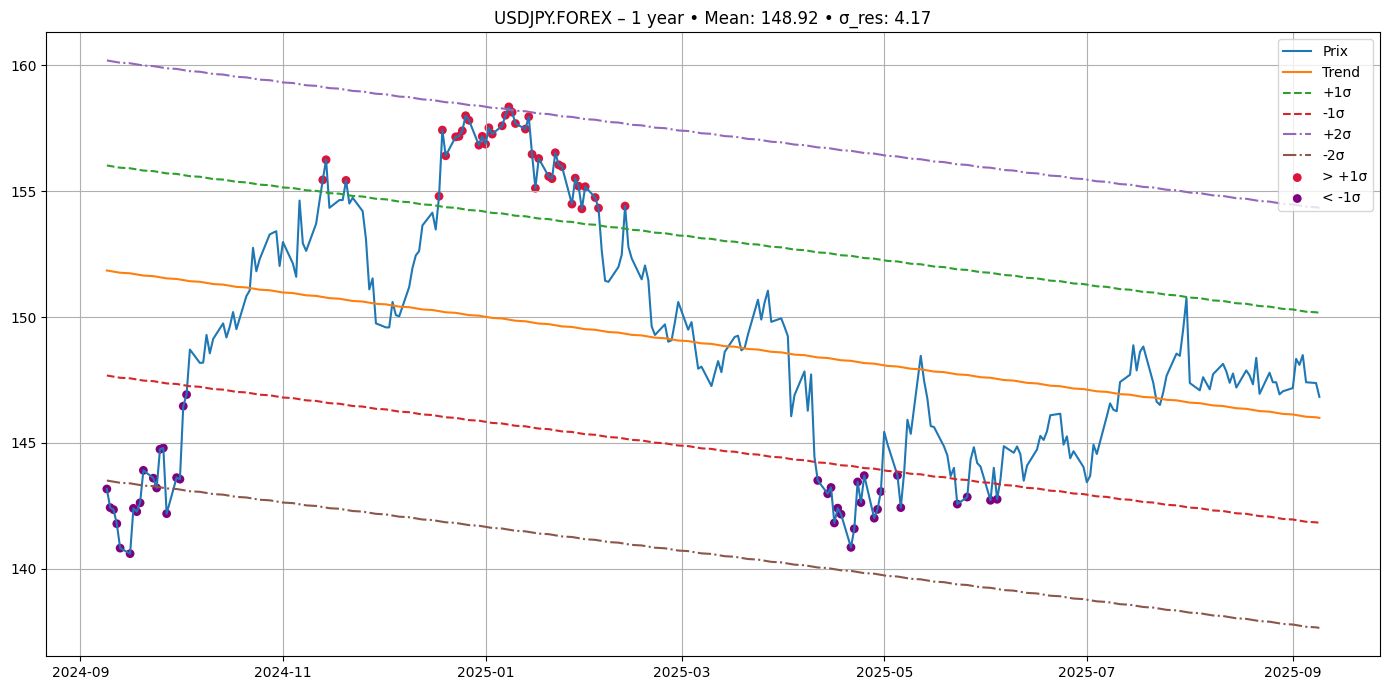

In [23]:
# OUTPUT


api_token = API_TOKEN
ticker = "USDJPY.FOREX"
end_date = pd.to_datetime('today').strftime('%Y-%m-%d')
start_1y = (pd.to_datetime(end_date) - pd.DateOffset(years=1)).strftime('%Y-%m-%d')
logger = Logger.setup()

# data collection and cleaning
data = get_daily_data(ticker, start_1y, end_date, API_TOKEN, logger).copy()
data = clean_data(data)

analysed_data = analysis(data, logger, True)


plot_with_quantification(data, f'{ticker} – 1 year')
